### **Scalable Portscan Detection using Apache Spark**

Network operators actively monitor their networks to protect the networks various intrusion attacks. These attackers routinely perform random `portscans` of IP addresses to find vulnerable servers to compromise. Network Intrusion Detection Systems (NIDS) attempt to detect such behavior and flag these portscanners as malicious. This assignment focuses on the Threshold Random Walk (TRW), an online algorithm that identifies malicious remote hosts. You can read the full paper [here](http://www.icir.org/vern/papers/portscan-oak04.pdf). 

In this assignment, you will analyze the passive network measurement data to understand the nature of malicious traffic in the campus networks. You will then simulate the performance of various online anomaly detection algorithms using the passive network measurement data. 

#### Traffic Measurement with IPFIX

We used the Netflow data in the previous assignment to explore large voluume traffic flows and other features of network traffic. 

In this part of the assignment, you'll use the similar NetFlow records, but for a different type of analysis: identifying malicious network traffic.

We have parsed these records into CSV (comma-separated variable) format, with the names of the fields listed in the first row of the file. (In a real network, routers export IPFIX records as binary files.) The flow records for this assignment are in the file 'netflow.csv' on Blackboard under course materials. You should download this file and place it in the directory 'assignment3/Portscan/data'.  


#### Distributed Data Analysis with MapReduce and Apache Spark

The volume of data generated by networks has become so large that it can be difficult to process the data on a single machine. Network operators can analyze more data, more quickly by relying on parallel data analysis techniques, which permits analysis of much more data and often faster responses to various network events (e.g., traffic shifts, attacks). 

In this assignment, you will use the Apache Spark framework to perform parallel data analysis. Apache Spark is a cluster computing technology, designed for fast computation. It is based on Hadoop MapReduce and it extends the MapReduce model to efficiently use it for more types of computations, which includes interactive queries and stream processing. 

This notebook has several parts. Each part starts with the instructions that you need to follow to complete the assignment. 

In [2]:
# Check that Spark is working
largeRange = sc.parallelize(xrange(100000))
reduceTest = largeRange.reduce(lambda a, b: a + b)
filterReduceTest = largeRange.filter(lambda x: x % 7 == 0).sum()

# If the Spark jobs don't work properly these will raise an AssertionError
assert reduceTest == 4999950000
assert filterReduceTest == 714264285

### Parsing IPFIX Data

IPFIX allows network devices to collect statistics about network traffic at each interface; Cisco NetFlow is a proprietary version of this standard. We have provided Cisco NetFlow data that we collected at Princeton's border router. The data is "unsampled"; in other words it compiles flow statistics for every packet that traverses any interface on the border router.

We used the `nfdump` tool to process the raw NetFlow data that the router collected. Each line, except for the header on top and the summary information at the bottom, logs the following information for a flow:
```
Date first seen,Date last seen,Duration, Proto, Src IP Addr, Src Pt,Dst IPAddr, Dst Pt, Packets, Bytes, Flags, Input, Output, Router IP, Next-hop IP, BGP next-hop IP, 
Src AS, Dst AS, SMask, DMask
```

##### Setup:  Parse the NetFlow data into a Spark data structure.
To process the data, we first need to create a Spark data structure called a resilient distributed dataset (RDD) with the name `flow_records`, where each entry in the RDD is a tuple:
```(tstart, srcip, srcport, dstip, dstport, bytes, flag, proto)```

An RDD is similar to any other structured data format, but it is designed to distribute across a cluster. In this assignment, you will manipulate your RDD locally within your virtual machine, but all of the code that you write to manipulate your RDD could in principle be distributed across a cluster.

In [3]:
import sys
import os
from test_helper import Test

import re
import datetime
from dateutil import parser

from pyspark.sql import Row

baseDir = os.path.join('data')
inputPath = os.path.join('netflow.csv')
logFile = os.path.join(baseDir, inputPath)


def parseLogLine(logline):
    """ TODO: Parse a line in the Netflow Log
    Args:
        logline (str): a line of text in the format:
        Date first seen,Date last seen,Duration, Proto, Src IP Addr, Src Pt,Dst IPAddr, Dst Pt, Packets,    
        Bytes, Flags, Input, Output, Router IP, Next-hop IP, BGP next-hop IP, Src AS, Dst AS, 
        SMask, DMask
    Returns:
        tuple: ((tstart, srcip, srcport, dstip, dstport, data, flag, proto), 1) for valid line,
               or the original invalid log line and 0
    """
    tokens = logline.split(',')
    if logline == ''or len(tokens) != 22 or '.' in tokens[7] or '.' in tokens[9]:
        return (logline, 0)
    else:
        return ((' '.join([tokens[0], tokens[1]]), tokens[6], tokens[7], tokens[8], tokens[9], tokens[11], tokens[12], tokens[5]), 1)
    # (date_first_seen, time_first_seen, src_ip, src_pt, dst_ip, dst_pt, bytes, flags, proto)
        

def parseNetflow():
    """ TODO: Read and parse log file """

    data = sc.textFile('./' + logFile)
    flow_records = data.map(parseLogLine).filter(lambda t: t[1] == 1)
    
    flow_records = flow_records.map(lambda t: t[0])
    
    return flow_records


flow_records = parseNetflow()
print "Number of flow records: ", flow_records.count()
print "Sample flow entries: ", flow_records.take(3)

Number of flow records:  100911
Sample flow entries:  [(u'2015-10-29 06:04:48.934', u'116.211.0.90', u'52704', u'128.112.186.67', u'9095', u'40', u'....S.', u'TCP'), (u'2015-10-29 06:04:48.934', u'74.82.47.46', u'35069', u'128.112.248.244', u'6379', u'40', u'....S.', u'TCP'), (u'2015-10-29 06:04:48.934', u'116.211.0.90', u'52704', u'128.112.186.124', u'9047', u'40', u'....S.', u'TCP')]


### ** Part 1: Analyzing TCP Flows**

In this part of the assignment, you will analyze TCP flow records to look for a TCP SYN scan attack. A [TCP SYN scan](https://en.wikipedia.org/wiki/Port_scanner#SYN_scanning) is similar to the TCP SYN flood attack that we discussed in lecture, except that a SYN scan sends a TCP SYN packet to many _different_ destination ports to determine whether machines on the network have open ports. 

Let's first begin by counting the number of TCP flow records in the traffic trace.

In [4]:
tcpFlowRecords = (flow_records
                    .filter(lambda s: str(s[7]) == 'TCP')
                    .cache()
                   )

##### TCP Flags for NetFlow Records

In the previous assignment, we analyzed destinations that receive popular destinations by number of flows and by overall traffic volume. Such higher level statistics provide a coarse view of the network anomalies, but these statistics reveal less useful information about attacks and intrusion attempts. 

Often moderately intensive worms and other abnormal activities appear intangible amongst the immense amount of legitimate traffic that is typically found in a large enterprise network. Those malicious hosts might not show up in lists of the top senders (either by bytes or by flows), and it can be difficult to determine the exact nature of the attack traffic in advance. 

Certain types of attacks have other characteristic features, however: Many attackers "scan" a network for hosts that have processes listening for TCP connections on certain ports (i.e., in the hopes of detecting a host running a vulnerable service). These scans manifest as flows with the TCP SYN flag set.  If a NetFlow record indicates that the flow contained a TCP SYN _but no packets with the ACK flag set_, we can conclude that this flow never completed and thus may be part of a TCP SYN scan---particularly if there are a lot of these flows.


##### TCP SYN Port Scan

When an attacker sends a TCP SYN packet as part of a TCP SYN scan, each probe corresponds to one of three possible outcomes:
- There is an active host at the destination IP address that is listening on the destination port of the SYN packet. In this case, the NetFlow record will contain both the TCP SYN and ACK flags in the flow record. These flows are difficult to distinguish from legitimate flows, because in this case a host actually answered the initial SYN. 
- There is no active host on the network at the destination IP address. In this case, we will only see TCP SYN flag. This is very different from the legitimate traffic behavior. It should be possible to identify scanner hosts analysing these flow records. 
- The destination is alive, but the port to which the SYN is sent is closed. If a client connects to a server's non-listening port, the server will send back a RST/ACK packet. According to normal TCP implementation guidelines, the host will immediately stop any TCP connection attempts once it receives a RST. The NetFlow record will only show SYN requests from the scanner host to the destination host.

Let's first explore our NetFlow trace to determine whether the Princeton University campus network observes significant traffic with TCP SYN flags only (i.e., flows with TCP SYNs but no ACKs). 

#### Exercise: Plot distribution of various TCP flags

In [5]:
# Helper scripts for plotting CDF and pie plots
import math
from matplotlib import pyplot as plt
%matplotlib inline

color_n = ['r','k','b','g','m','k','w']
markers = ['o','*','^','s','d','3','d','o','*','^','1','4']
linestyles = [ '-',':','--','-.','--',':','-','-.', '--',':','-','-.', 
            '--',':','-','-.', '--',':','-','-.', '--',':','-','-.']

    

# Plot CDFs
def plotCDF(data, xlabel, ylabel, Xmax, Xmin, labels):
    """ Plot CDF
    Args:
        data: a dict of multiple data points
        xlabel: x-axis label
        ylabel: y-axis label
        Xmax: max value to plot for x-axis
        Xmin: min value to plot for x-axis
        labels: labels for the input data
    Returns:
        None
    """
    xlab=[]
    raw={}
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    p1=[]
    legnd=[]
    i=0

    for key in labels:
        raw[key]=data[key]
        raw[key].sort(reverse=True)
        num_bins=10000
        counts, bin_edges = np.histogram(raw[key],bins=num_bins,normed=True)
        cdf=np.cumsum(counts)
        scale = 1.0/cdf[-1]
        cdf=cdf*scale
        p1.append([])
        plt.plot(bin_edges[1:], cdf, label=key, color=color_n[i]
                ,linestyle=linestyles[0], linewidth=3.0
               )
        i+=1

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if Xmin != 'N/A':
        ax.set_xlim(xmin=Xmin)
    if Xmax != 'N/A':
        ax.set_xlim(xmax=Xmax)
    ax.set_ylim(ymax=1.0)
    ax.set_ylim(ymin=0.0)
    ax.grid(True)
    plt.tight_layout()
    pass

# Plot pi-charts 
def pie_pct_format(value):
    return '' if value < 3 else '%.0f%%' % value

def plot_pie_chart(fracs, labels):
    """ Plot Pie chart
    Args:
        frac: a list of fractions for the pie chart
        labels: list of labels for the input frac
    Returns:
        None
    """
    fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
    colors = ['purple', 'lightskyblue', 'yellowgreen', 'gold', 'lightcoral', 'yellow',
             'orange','lightgreen','darkblue','pink']
    #explode = (0.05, 0.05, 0.1, 0, 0, 0,0.1, 0, 0, 0)
    patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                        #explode=explode, 
                                        autopct=pie_pct_format,
                                        shadow=False,  startangle=250)
    for text, autotext in zip(texts, autotexts):
        if autotext.get_text() == '':
            text.set_text('')  # If the slice is small to fit, don't show a text label
    plt.legend(labels, loc=(0.80, -0.1), shadow=True)
    pass

[(u'.A.RS.', 4)]
Found 10 TCP Flag combinations


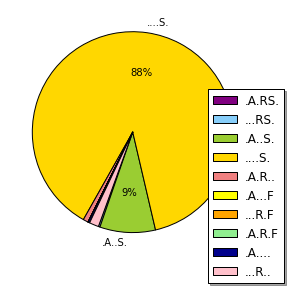

In [7]:



# Exercise
tcpFlagRecords = tcpFlowRecords.map(lambda t: (t[6], 1)).reduceByKey(lambda a,b: a + b)
print tcpFlagRecords.take(1)
total_records = tcpFlagRecords.reduce(lambda a,b: (a[0], a[1]+b[1]))[1]
label_fracs = tcpFlagRecords.map(lambda t: (t[0], t[1]/float(total_records))).collect()
tcpFlagToCountList = tcpFlagRecords.collect()
print 'Found %d TCP Flag combinations' % len(tcpFlagToCountList)

# Extract frac and labels
labels = map(lambda t: t[0], label_fracs)
fracs = map(lambda t: t[1], label_fracs)

# Plot the pie chart
plot_pie_chart(fracs, labels)

Observe what the plots tells us about the number of traffic flows that contain only TCP SYN flags, with no corresponding ACK flags.

### **Part 2: Port Scan Detection Using IPFIX Data**

A network operator can analyze IPFIX data to determine which hosts are sending port scan traffic to its network. It can classify all the source IP addresses into known bad traffic flows and the remainder. 

- _known bad_ hosts are the one that match one or more definition of bad behavior. In this assignment we will consider hosts that try to send traffic to some know bad TCP ports. These ports are: 135/tcp, 139/tcp, 445/tcp, or 1433/tcp. These correspond to Windows RPC, NetBIOS, SMB, and SQL-Snake attacks. We expect that most of these `known_bad` hosts are scanners, but that is not necessarily true for all the `known_bad` hosts.

- _remainder_ are the hosts that do not fall into teh category of `known_bad` hosts, as described above; this traffic contains both attackers who sent TCP SYN scans and benign hosts. We can observe the connectivity behavior of these hosts to determine which hosts are likely scanners and which hosts are benign. 

##### **Metric 1: Number of unique destination IP addresses with failed connections.**

Let's first detect likely SYN scan attackers by identifying remote hosts that make failed connection attempts (i.e., flows with only the SYN flag set, with no ACK flag ever set) to a large number of IP addresses. We'll compare the distribution of the number of distinct IP addresses accessed by `known_bad` vs. those accessed by the `remainder` by looking at a cumulative distribution function (CDF). (A CDF is a common way for network analysts to understand the distribution of various traffic characteristics.)

The `remainder` hosts comprise both `scanners` and `benign` hosts. Thus, we expect the CDF to show two pronounced modalities, corresponding to each of these classes of hosts. 

**Note**: Although the NetFlow collector at Princeton University is downstream of the campus intrustion detection system, we are unsure of what that device blocks are permits because we do not know its exact configuration.


In [8]:
known_bad_ports = [135,139,445,1433]

def is_bad(t):
    port = int(t[4])
    flag = t[6]
    return port in known_bad_ports

failed = tcpFlowRecords.filter(lambda t: t[6] == '....S.')


bad = failed.filter(lambda t: is_bad(t))
remainder = failed.filter(lambda t: not is_bad(t))

badSrc_2_inactiveDst = bad \
                                     .map(lambda t: (t[1], t[3])) \
                                     .distinct() \
                                     .map(lambda t: (t[0], 1)) \
                                     .reduceByKey(lambda a,b: a+b)
        
remainderSrc_2_inactiveDst = remainder \
                                     .map(lambda t: (t[1], t[3])) \
                                     .distinct() \
                                     .map(lambda t: (t[0], 1)) \
                                     .reduceByKey(lambda a,b: a+b)

        

print badSrc_2_inactiveDst.take(10), badSrc_2_inactiveDst.count()
print remainderSrc_2_inactiveDst.take(10), remainderSrc_2_inactiveDst.count()


[(u'86.188.130.238', 1), (u'89.26.123.81', 1), (u'2.50.2.38', 1), (u'128.112.133.122', 2), (u'117.194.114.15', 1), (u'118.175.28.39', 1), (u'114.37.95.187', 2), (u'188.36.150.81', 1), (u'193.106.125.67', 1), (u'59.95.23.13', 1)] 1123
[(u'49.142.226.98', 1), (u'182.52.148.207', 256), (u'104.156.228.147', 32), (u'173.178.186.44', 1), (u'218.28.92.228', 1), (u'27.208.166.28', 1), (u'117.13.10.93', 1), (u'86.40.88.79', 6), (u'119.137.250.49', 1), (u'115.29.2.4', 31)] 3382


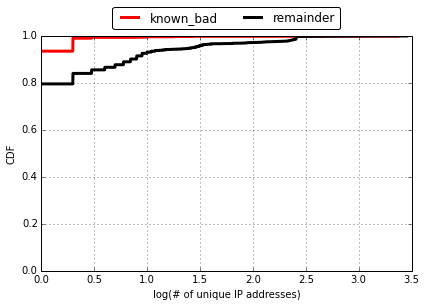

In [9]:
import numpy as np

plot_data = {}
labels = ["known_bad", "remainder"]
plot_data["known_bad"] = [math.log(x[1],10) for x in badSrc_2_inactiveDst.collect()]
plot_data["remainder"] = [math.log(x[1],10) for x in remainderSrc_2_inactiveDst.collect()]
plotCDF(plot_data, "log(# of unique IP addresses)", "CDF", 'N/A', 0, labels)

You should observe two modes in the conenctivity behavior for the `remainder` hosts. Also, if you see multiple modes among the `known_bad` hosts, think about what those multiple modes might reflect.

##### **Metric 2: Percentage of unique IP addresses with failed connections.**

Another metric that can help detect a SYN scan is the percentage of destination IP addresses that a given source IP address has accessed for which the connection attempt failed; we define this metric as `inactive_pct`. 

We will now compare this metric for both hosts in each of the `remainder` and `known_bad` classes.

In [10]:
inactive_TCP = '....S.'
badSrc_2_inactive_pct = tcpFlowRecords.filter(is_bad)\
                                      .map(lambda t: ((t[1], t[3]), t[6] == inactive_TCP))\
                                      .reduceByKey(lambda a,b: a)\
                                      .map(lambda t: (t[0][0], t[1]))\
                                      .reduceByKey(lambda a,b: a)\
                                      .map(lambda t: (t[0], np.mean(t[1]) * 100.0))
remainderSrc_2_inactive_pct = tcpFlowRecords.filter(lambda t: not is_bad(t))\
                                      .map(lambda t: ((t[1], t[3]), t[6] == inactive_TCP))\
                                      .reduceByKey(lambda a,b: a)\
                                      .map(lambda t: (t[0][0], t[1]))\
                                      .reduceByKey(lambda a,b: a)\
                                      .map(lambda t: (t[0], np.mean(t[1]) * 100.0))

print badSrc_2_inactive_pct.take(10), badSrc_2_inactive_pct.count()
print remainderSrc_2_inactive_pct.take(10), remainderSrc_2_inactive_pct.count()

[(u'86.188.130.238', 100.0), (u'89.26.123.81', 100.0), (u'2.50.2.38', 100.0), (u'128.112.133.122', 100.0), (u'117.194.114.15', 100.0), (u'118.175.28.39', 100.0), (u'114.37.95.187', 100.0), (u'188.36.150.81', 100.0), (u'193.106.125.67', 100.0), (u'59.95.23.13', 100.0)] 1126
[(u'128.112.5.80', 0.0), (u'182.52.148.207', 100.0), (u'104.156.228.147', 100.0), (u'173.178.186.44', 100.0), (u'218.28.92.228', 100.0), (u'27.208.166.28', 100.0), (u'117.13.10.93', 100.0), (u'86.40.88.79', 100.0), (u'119.137.250.49', 100.0), (u'115.29.2.4', 100.0)] 3618


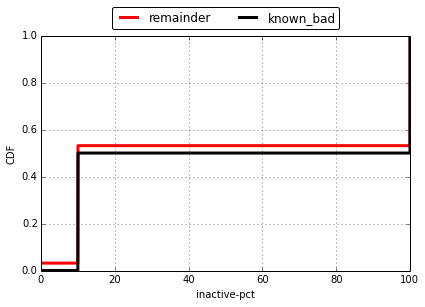

In [11]:
plot_data = {}
labels = [
          "remainder", "known_bad"
         ]
plot_data["known_bad"] = [(x[1],10) for x in badSrc_2_inactive_pct.collect()]
plot_data["remainder"] = [(x[1],10) for x in remainderSrc_2_inactive_pct.collect()]
plotCDF(plot_data, "inactive-pct", "CDF", 100, 0, labels)

You should see two modes in the connection behavior of hosts in the `remainder` class.

##### Enumerate different types of hosts

Based on this observation, you should determine a threshold for the percentage of failed connections to identify attackers. Suppose that this threshold is _T_. 

So we will enumerate the following three classes of hosts:
- `known_bad`: as defined above.
- `benign`: hosts in `remainder` with `inactive-pct` less than or equal to threshold T.
- `suspect`: hosts in `remainder` with `inactive-pct` greater than threshold T.

In [28]:
T = 30
known_bad_srcs = [x[0] for x in badSrc_2_inactive_pct.collect()]
benign_srcs = [x[0] for x in remainderSrc_2_inactive_pct.collect() if x[1] < T]
suspect_srcs = [x[0] for x in remainderSrc_2_inactive_pct.collect() if x[1] >= T]

print "Number of known_bad sources:", len(known_bad_srcs)
print "Number of benign sources:", len(benign_srcs)
print "Number of suspect sources:", len(suspect_srcs)

Number of known_bad sources: 1126
Number of benign sources: 237
Number of suspect sources: 3381


### **Part 3: Online Port Scan Detection**

The previous part of the assignment performed detection of SYN scans using offline NetFlow traces. Computing each of the statistics that we looked at would require capturing and analyzing the complete trace, as opposed to computing an "online" statistic that updated based on an incoming stream of data. 

In this part of the assignment, you will implement two _online_ port scan detection algorithms that can detect 

- Bro's Port Scan Detection Algorithm
- TRW Port Scann Detection Algorithm

#### **Bro's Port Scan Detection Algorithm**

Bro's detection algorithm builds on the same intution that failed connection attempts are good indicators for identifying scans. As we have already discussed, because scanners have little knowledge of network topology and system configuration, they are likely to often choose an IP address or port that is not active. 

The algorithm itself treats connection attempts different depending on each service. IF the connection attempt corresponds to a service specified in a list enumerated in the configuration, Bro only performs bookkeeping for failed connection attempts (i.e., a SYN that either does not receive an ACK or receives a RST).

Bro then tracks all other connection attempts for unspecified services, whether or not the attempt failed or succeeded. Bro sums the number of distinct destination addresses for connection attempts from any given source address. If the number exceeds some threshold, _T_, Bro flags the source address as a scanner.

By default, Bro sets T = 100 addresses and the set of services for which only failures are considered to HTTP (80), SSH (22), Telnet (23), SMTP (25), IDENT (113), FTP (20), and Gopher (70). 

##### Exercise: Implement Bro's port scan detection algorithm.

In [13]:
def process_netflow_log_bro(tmp):
#     print tmp
    srcip = tmp[1]
    dstip = tmp[3]
    flag = tmp[6]
    dstport = int(tmp[4])
    if flag != '....S.':
        return (srcip, dstip, dstport, 1)
    else:
        return (srcip, dstip, dstport, 0)
    
    
# flow_records = flow_records.collect()
def bro_portscan_detection(fname, ports_considered, Thresh):
    # dict of src IP to # of failed connections to "ports_considered"
    failure_counter = {}
    # disct of scanner IP address to # of failed connections to "ports_considered"
    scanners = {}
    # implement the detection logic
    src_to_dst = {}
    
    flow_records = parseNetflow().filter(lambda s: str(s[7]) == 'TCP').cache().collect()
    
    # The algorithm itself treats connection attempts different depending on each service. 
    # IF the connection attempt corresponds to a service specified in a list enumerated in the configuration, 
    # Bro only performs bookkeeping for failed connection attempts (i.e., a SYN that either does not receive
    # an ACK or receives a RST).
    # Bro then tracks all other connection attempts for unspecified services, whether or not the attempt 
    # failed or succeeded. Bro sums the number of distinct destination addresses for connection attempts from any 
    # given source address. If the number exceeds some threshold, T, Bro flags the source address as a scanner.
    

    for record in flow_records:
        srcip, dstip, dstport, success_flag = process_netflow_log_bro(record)
        
        if dstport in ports_considered and success_flag == 0:   # if we have ....S.
            if srcip in failure_counter: 
                failure_counter[srcip] += 1
            else:
                failure_counter[srcip] = 1
                
        if dstport not in ports_considered:
            if srcip in src_to_dst and dstip in src_to_dst[srcip]:   # already seen this srcip,dstip pair
                continue
            else:
                if srcip in src_to_dst:
                    src_to_dst[srcip].append(dstip)
                else:
                    src_to_dst[srcip] = [dstip]
            
            if srcip in failure_counter:
                failure_counter[srcip] += 1
            else:
                failure_counter[srcip] = 1
                
            
    
    for srcip in failure_counter.keys():
        if failure_counter[srcip] > Thresh:
            scanners[srcip] = failure_counter[srcip]
                
    
    return scanners

We will now observe the sensitivity of this port scan detection algorithm to the `threshold` variable? 

1 899
2 635
4 525
8 341
16 228
32 167
64 127
128 106


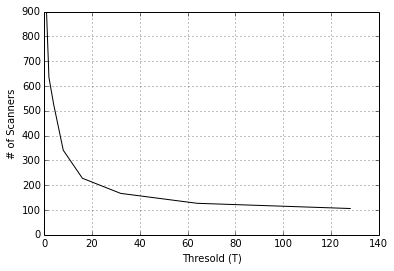

In [14]:
# TCP ports only
ports_considered = [80, 22, 23, 25, 113, 20, 70]
thresolds = [1,2,4,8,16,32,64,128]
x = []
y = []
for T in thresolds:
    scanners = bro_portscan_detection(logFile, ports_considered, T)
    print T, len(scanners.keys())
    x.append(T)
    y.append(len(scanners.keys()))  
f, (ax1) = plt.subplots(1)
ax1.plot(x, y ,color='k')
ax1.grid(True)
plt.xlabel('Thresold (T)')
plt.ylabel('# of Scanners')
ax1.set_ylim(ymin=0.0)
plt.show()
pass


# 782, 386, 174

In [15]:
T = 4 # is this choice of threshold reasonable?
bro_scanners = bro_portscan_detection(logFile, ports_considered, T)

Justify the choice of parameter T = 4 for TRW port scan detection? 

4 seems reasonable (but maybe a little small). We would choose a value for T in the range of 5 - 20 since this is where the inflection point of the curve occurs. If we cared a lot about security we would make T on the smaller side. But if we didn't care about security or knew we were secure, we would make T on the larger side to provide a better experience.

### **TRW Port Scan Detection Algorithm**

The _Threshold Random Walk (TRW)_ port scan detection algorithm builds on the intuition that a scanner is more likely than a legitimate host make connection attempts to destination IP addresses that either are unresponsive to that connection attempt (either because there is no host at the address, or because the host is not listening on the specified port). 

In contrast to Bro, whose threshold is hard-coded, the TRW port scan detection algorithm has a tunable threshold based on maximum likelihood ratios. It maintains a counter that continually increases (or respectively, decreases) its respective conditional probabilities of the host being a scanner, given a certain number of failed (or respectively, successful) connection attempts. This continual adjustment of the conditional probability gives the detection algorithm its name of Treshold Random Walk.

TRW the basis for an online algorithm whose goal is to reduce the number of observed connection attempts required to detect the scanner (compared to, say, Bro's scan detection algorithm), while bounding the missed detection and false positive probabilities.

#### Exercise: Implement TRW port scan detection algorithm as described in this [paper](http://www.icir.org/vern/papers/portscan-oak04.pdf)

In [30]:
def process_netflow_log_trw(tmp):
    srcip = tmp[1]
    dstip = tmp[3]
    flag = tmp[6]
    if flag != '....S.':
        return (srcip, dstip, 0)
    else:
        return (srcip, dstip, 1)
    
def trw_portscan_detection(fname, Pd, Pf, theta1, theta0):
    
    flow_records = parseNetflow().filter(lambda s: str(s[7]) == 'TCP').cache().collect()
    
    # D[s] is the list of distinct IP addresses to which s has previously made connections
    D = {}
    
    # S[s] reflects the decision state, one of: PENDING (2);H0 (0); or H1 (1)
    # in other words, 
    # S[s] = 2 => PENDING state,
    # S[s] = 1 => H1 is true, and 
    # S[s] = 0 => H0 is true
    S = {}
    
    # L[s] is the likelihood ratio for s
    L = {}
    
    # upper thresold
    eta1 = Pd/Pf
    
    # lower thresold
    eta0 = (1-Pd)/(1-Pf)
    
    
    # implement the detection logic
    for record in flow_records:
        
        srcip, dstip, success_flag = process_netflow_log_trw(record)
        
        # have not seen source
        if srcip not in S:
            
            D[srcip] = [dstip]
            
            if success_flag == 0:
                L[srcip] = theta1 / theta0
            else:
                L[srcip] = (1 - theta1) / (1 - theta0)
                
            if L[srcip] >= eta1:
                S[srcip] = 1
            elif L[srcip] <= eta0:
                S[srcip] = 0
            else:
                S[srcip] = 2
                
        # seen source ip
        else:  # srcip is in S
            if S[srcip] != 2:
                continue
                
            if dstip not in D[srcip]:
                D[srcip].append(dstip)
                
                if success_flag == 0:
                    L[srcip] *= theta1 / theta0
                else:
                    L[srcip] *= (1 - theta1) / (1 - theta0)
    
                if L[srcip] >= eta1:
                    S[srcip] = 1
                elif L[srcip] <= eta0:
                    S[srcip] = 0
    
    
    
    # Enumerate different types of hosts
    pending_hosts = []
    H1 = []
    H0 = []
    for source in S:
        if S[source] == 2:
            pending_hosts.append(source)
        elif S[source] == 1:
            H1.append(source)
        else:
            H0.append(source)
    return pending_hosts, H1, H0

We will now observe the sensitivity of the TRW port scan detection algorithm to the 
`detection probability (Pd)` variable.

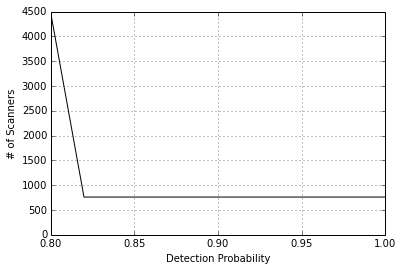

In [31]:
theta1 = 0.1
theta0 = 0.9
x = []
y = []

# Tuning detection probability
Pds = range(80,102,2)
for Pd in Pds:
    Pf = 0.09
    Pd = float(Pd)/100
    pending_hosts, H1, H0 = trw_portscan_detection(logFile, Pd, Pf, theta1, theta0)
    x.append(Pd)
    y.append(len(H1))
    #print Pf, Pd, len(H1)

f, (ax1) = plt.subplots(1)
ax1.plot(x, y ,color='k')
ax1.grid(True)
plt.xlabel('Detection Probability')
plt.ylabel('# of Scanners')
#ax1.set_xlim(xmin=0.0)
ax1.set_ylim(ymin=0.0)
plt.show()
pass

We will now observe the sensitivity of this port scan detection algorithm to the 
`false alarm rate (Pf)` variable. 

In [ ]:
# Tuning false alarm rate
x = []
y = []
# false alarm rate
Pfs = range(1,11,1)
for Pf in Pfs:
    Pf = float(Pf)/100
    Pd = 0.9
    pending_hosts, H1, H0 = trw_portscan_detection(logFile, Pd, Pf, theta1, theta0)
    x.append(Pf)
    y.append(len(H1))
    #print Pf, Pd, len(H1)
    
f, (ax1) = plt.subplots(1)
ax1.plot(x, y ,color='k')
ax1.grid(True)
plt.xlabel('False Alarm Rate')
plt.ylabel('# of Scanners')
#ax1.set_xlim(xmin=0.0)
ax1.set_ylim(ymin=0.0)
plt.show()
pass

In [ ]:
Pd = 0.90 # is this choice of Pd reasonable?
Pf = 0.05 # is this choice of Pf reasonable?
pending_hosts, H1, H0 = trw_portscan_detection(logFile, Pd, Pf, theta1, theta0)
trw_scanners = H1

Justify the choice of parameters Pf=0.05 and Pd=0.90 for TRW port scan detection.

Pf = 0.05 and Pd = 0.90 are reasonable because they are in the flat areas of the false alarm and detection probability parts. This means that these values don't produce results that are overly sensitive. If we made Pf > 0.08 or Pd < 0.85 we might start to misclassify benign scanners. 

In [29]:
print "suspect_sources ", len(suspect_srcs)
print "bro identified scanners ", len(bro_scanners)
print "trw identified scanners ", len(trw_scanners)

suspect_sources  3381
bro identified scanners  525
trw identified scanners  43
